# Aim

Go through all the steps of system identification for vibrations and make a better dynamic model of telescope tip-tilt aberrations based on that. This is first being built in this notebook, then it'll be incorporated into `tiptilt.py`.

## Steps

1. Make vibration data over some time.
2. Find its PSD.
3. Filter out measurement noise and curve-fit the PSD of measurement noise to find its spread.
4. Curve-fit remaining PSD to an atmosphere model.
5. Curve-fit remaining PSD to that of arbitrary vibration modes till a certain number of vibration modes has been reached or till the last one has negligible energy.
6. Construct Q based on the number of vibe modes.
7. Find AR2 state-evolution coefficients based on results of 4 and 5, and make new state-transition matrix A.
8. Run a simulation without filtering and without control action.
9. Run a simulation without filtering, but with control action.
10. Run a simulation with filtering and with control action.

In [1]:
# imports

import numpy as np
from scipy import optimize, signal, interpolate, stats
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# global parameter definitions

f_sampling = 2000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 10 # number of vibration modes being applied
N_vib_max = 10 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook
time_id = 2 # timescale over which sysid runs. Pulled from Meimon 2010's suggested 1 Hz sysid frequency.

Text(0.5,1,'Vibrations with and without measurement noise')

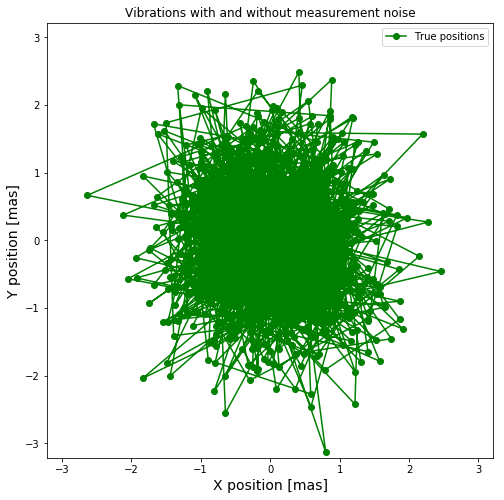

In [2]:
# step 1: making vibration data

times = np.arange(0, time_id, 1/f_sampling)
vib_freqs    = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_phase   = np.random.uniform(low=0.0, high=0.0, size=N_vib_app)  # radians
vib_damping  = np.random.uniform(low=1e-4, high=1e-3, size=N_vib_app) # unitless

# vibrations are vib_amps[i] sin/cos(vib_pa[i]) exp(-vib_damping[i] vib_freqs[i] t) exp(i*(vib_freqs[i] t - vib_phase[i])).

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

dx = sum([-vib_amps[i]*np.sin(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])
dy = sum([vib_amps[i]*np.cos(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])

# measurement noise
dx_noisy = dx + np.random.normal(0, measurement_noise, np.size(times))
dy_noisy = dy + np.random.normal(0, measurement_noise, np.size(times))

plt.figure(figsize=(8, 8))
plt.plot(dx, dy, 'go-', label='True positions')
#plt.plot(dx_noisy, dy_noisy, 'ro-', label='Noisy positions')
plt.xlabel('X position [mas]',fontsize=14)
plt.ylabel('Y position [mas]',fontsize=14)
lim = max(np.max(np.abs(dx_noisy)), np.max(np.abs(dy_noisy)))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

plt.legend()
plt.title('Vibrations with and without measurement noise')
#plt.title('Vibrations without measurement noise')

In [3]:
# step 2: find PSD
# TODO: refactor (probably in the class implementation) so that this only operates on one mode at a time.

_, psd_tip_true = signal.periodogram(dx, f_sampling)
freqs, psd_tip = signal.periodogram(dx_noisy, f_sampling)
_, psd_tilt_true = signal.periodogram(dy, f_sampling)
_, psd_tilt = signal.periodogram(dy_noisy, f_sampling)

(1e-07, 1)

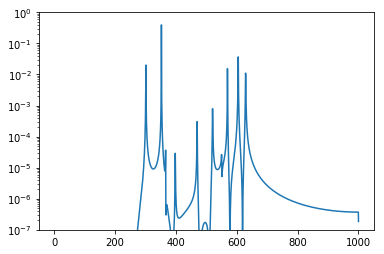

In [4]:
plt.semilogy(freqs, psd_tip_true) # tilt is similar, but with slightly different peak amplitudes.
plt.ylim(1e-7,1)

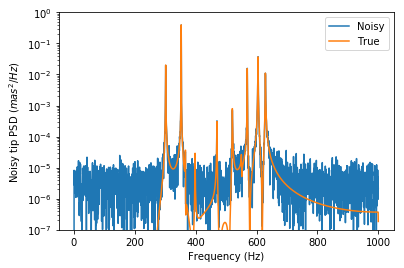

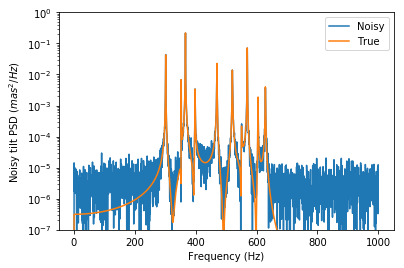

In [5]:
plt.semilogy(freqs, psd_tip, label='Noisy')
plt.semilogy(freqs, psd_tip_true, label='True')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tip PSD $(mas^2/Hz)$")
plt.legend()
plt.show()

plt.semilogy(freqs, psd_tilt, label='Noisy')
plt.semilogy(freqs, psd_tilt_true, label='True')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tilt PSD $(mas^2/Hz)$")
plt.legend()
plt.show()

In [6]:
# step 3: filter out measurement noise

ind = np.argmax(freqs > f_w)
assert ind != 0, "didn't find a high enough frequency"
noise_psd = (psd_tip[ind:] + psd_tilt[ind:])/2
avg_measurement_power = np.mean(noise_psd)

measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
print("Recovered measurement noise: " + str(measurement_noise_recovered))
print("Percent error in measurement noise estimate: " + str(100 * np.abs(measurement_noise_recovered - measurement_noise)/measurement_noise))

psd_tip -= avg_measurement_power
psd_tilt -= avg_measurement_power

# this subtraction is problematic because it goes negative, so quick correction here. Want a better way of doing this.

for psd in [psd_tip, psd_tilt]:
    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = min(psd[psd > 0])

# squelch: removing noise by applying a smoothing filter (convolution with [0.05, 0.1, 0.7, 0.1, 0.05])
conv_peak = 0.7
assert conv_peak < 1, "convolution must have unit gain"
side = 1 - conv_peak
kernel = np.array([side/6, side/3, conv_peak, side/3, side/6])
c = kernel.size//2
psd_tip_smooth = np.convolve(psd_tip, kernel)[c:-c]
psd_tilt_smooth = np.convolve(psd_tilt, kernel)[c:-c]

# ad hoc low-pass filter
ind_cutoff = np.argmax(freqs > f_w)
psd_tip_smooth[ind_cutoff:] = np.zeros(len(psd_tip_smooth) - ind_cutoff)
psd_tilt_smooth[ind_cutoff:] = np.zeros(len(psd_tilt_smooth) - ind_cutoff)

'''# and also a high-pass filter
ind_cutoff = np.argmin(freqs < f_1)
psd_tip_smooth[:ind_cutoff] = np.zeros(ind_cutoff)
psd_tilt_smooth[:ind_cutoff] = np.zeros(ind_cutoff)'''

# bring the peaks back to where they were
cutoff_amp = 1e-4 # arbitrary - should replace by some function of the measurement noise
peak_ind_tip = signal.find_peaks(psd_tip_smooth, height=cutoff_amp)[0]
peak_ind_tilt = signal.find_peaks(psd_tilt_smooth, height=cutoff_amp)[0]
for i in peak_ind_tip:
    psd_tip_smooth[i] = psd_tip_smooth[i]/conv_peak
for i in peak_ind_tilt:
    psd_tilt_smooth[i] = psd_tilt_smooth[i]/conv_peak
psd_tip = psd_tip_smooth
psd_tilt = psd_tilt_smooth

Recovered measurement noise: 0.08990798407144864
Percent error in measurement noise estimate: 49.846640119081066


Text(0.5,1,'Recovered+filtered and true PSDs')

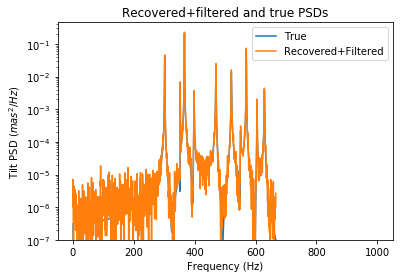

In [7]:
plt.semilogy(freqs, psd_tilt_true, label='True')
plt.semilogy(freqs, psd_tilt_smooth, label='Recovered+Filtered')
plt.ylim(1e-7, 2*max(psd_tilt))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Tilt PSD $(mas^2/Hz)$")
plt.legend()
plt.title("Recovered+filtered and true PSDs")
# filter isn't totally accurate, but it mostly picks out the peaks cleanly
# could try and LPF the noise (which I guess would be slicing in time because fft of fft) but could also just not

In [8]:
# step 5: curve-fitting PSD to vibration modes (skipping over 4 at the moment because there's no atmosphere)
# about five partial approaches deleted, because git checkout is a thing
# TODO: mode energy cutoff

def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

def psd(pars_model):
    return signal.periodogram(damped_harmonic(pars_model), fs=f_sampling)[1]

def log_likelihood(func, data):
    def get_ll(pars):
        pars_model, sd = pars[:-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(stats.norm.logpdf(data, loc=data_predicted, scale=sd))
        return LL
    return get_ll

par0 = [0.5, 250, 1e-4, np.pi, 0.2]
PARAMS_SIZE = len(par0) - 1

# peak detection by correlation
indshift = int(5*time_id) # index shift rescaling a freq shift of 5 Hz due to ID time; 
# number of samples goes up because more time
reference_peak = psd(par0[:-1])
center = np.argmax(reference_peak)
reference_peak = reference_peak[center-indshift:center+indshift] 
# any random peak should do; should be independent of the data though.

peaks = []
psd_windowed = copy.deepcopy(psd_tip_smooth)
for i in range(2*N_vib_max):
    peak = np.argmax(np.correlate(psd_windowed, reference_peak, 'same'))
    peaks.append(peak)
    psd_windowed[peak-indshift:peak+indshift] = 1e-6
    if i == N_vib_max:
        psd_windowed = copy.deepcopy(psd_tilt_smooth)
    
params = np.zeros((2*N_vib_max, PARAMS_SIZE))
variances = np.zeros(2*N_vib_max)

# curve-fit to each identified peak and find corresponding parameters
# currently, the number of identified peaks is always the maximum possible
# since the idea of an 'applied vibration mode' exists only in simulation, this seems reasonable
active_psd = psd_tip
for i, peak_ind in enumerate(peaks):
    l, r = peak_ind - indshift, peak_ind + indshift
    windowed = active_psd[l:r]
    psd_ll = log_likelihood(lambda pars: psd(pars)[l:r], windowed)
    par0[1] = freqs[peak_ind] # use an identified peak as a good starting point
    A, k, p, sd = optimize.minimize(psd_ll, par0, method='Nelder-Mead').x
    params[i] = [A, f, k, p]
    variances[i] = sd**2
    if i == N_vib_max:
        active_psd = copy.deepcopy(psd_tilt)

In [9]:
'''print("x amplitude: ", -vib_amps[0] * np.sin(vib_pa[0]))
print("y amplitude: ", vib_amps[0] * np.cos(vib_pa[0]))
print("frequency: ", vib_freqs[0])
print("damping: ", vib_damping[0])
print("phase offset: ", vib_pa[0])'''

'print("x amplitude: ", -vib_amps[0] * np.sin(vib_pa[0]))\nprint("y amplitude: ", vib_amps[0] * np.cos(vib_pa[0]))\nprint("frequency: ", vib_freqs[0])\nprint("damping: ", vib_damping[0])\nprint("phase offset: ", vib_pa[0])'

1.8772585177106753


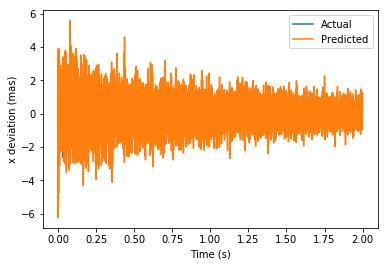

In [10]:
plt.plot(times, dx, label='Actual')
predicted_x = sum([damped_harmonic(params[i]) for i in range(N_vib_max)])
plt.plot(times, predicted_x, label='Predicted')
plt.xlabel("Time (s)")
plt.ylabel("x deviation (mas)")
print(np.std(dx - predicted_x)/np.std(dx))
plt.legend()

7.8007224303272675


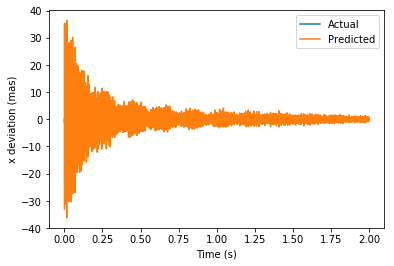

In [11]:
plt.plot(times, dy, label='Actual')
predicted_y = sum([damped_harmonic(params[i]) for i in range(N_vib_max, 2*N_vib_max)])
plt.plot(times, predicted_y, label='Predicted')
plt.xlabel("Time (s)")
plt.ylabel("x deviation (mas)")
print(np.std(dy - predicted_y)/np.std(dy))
plt.legend()

In [12]:
# step 6: define Q for tip and tilt, then combine them for our eventual full dynamic system.

STATE_SIZE = 4*N_vib_max # 'N_vib_max' modes each for tip and tilt, and because AR2, those modes one timestep ago.
Q = np.zeros((STATE_SIZE, STATE_SIZE))
for i in range(2*N_vib_max):
    Q[2*i][2*i] = variances[i]
    # Meimon 2010 doesn't explicitly cover process noise covariance generation
    # so I just assume all the modes are uncorrelated
    # and that there's no additional noise associated with the time-delay steps
    

In [13]:
# step 7: find AR2 state-evolution coefficients and construct A

# convention: a_ji, j is the number of the coefficient (1 or 2), i is the number of the vibe mode

A = np.zeros((STATE_SIZE, STATE_SIZE))
for i in range(2*N_vib_max):
    k = params[i][2]
    f = params[i][1]
    a_1i = 2 * np.exp(-2*k*np.pi*f/f_sampling) * np.cos(2*np.pi*f*np.sqrt(1-k**2)/f_sampling)
    a_2i = -np.exp(-4*k*np.pi*f/f_sampling)
    A[2*i][2*i] = a_1i
    A[2*i][2*i+1] = a_2i
    A[2*i+1][2*i] = 1

In [14]:
# step 7: set up state-space model

# all of this stuff will be moved into a DynamicSystem child class later.
# DynamicSystem isn't set up to deal with the D matrix.
# Right now, for independence, I'm going to copy over the predict and update methods and run them in a loop.

INPUT_SIZE = 2 # but this is only applied to the measurements
MEASUREMENT_SIZE = 2 # measuring dx, dy

state_init = np.random.normal(0, np.diag(Q), STATE_SIZE)
# state starts with white process noise, otherwise it never evolves.
# state doesn't include dx and dy and has no dependence on the control input
# so if it's not started at something nonzero and allowed to evolve based on sysID
# then vibrations are just identified as zero for all time.
# this seems sketchy though.

H = np.zeros((2, STATE_SIZE))
for i in np.arange(0, 2*N_vib_max, 2):
    H[0][i] = 1

for i in np.arange(2*N_vib_max, 4*N_vib_max, 2):
    H[1][i] = 1
    
P = np.zeros((STATE_SIZE, STATE_SIZE))
R = measurement_noise * np.identity(MEASUREMENT_SIZE)
D = np.identity(2)

def evolve():
    return (A, np.zeros((STATE_SIZE, INPUT_SIZE)))

def ext_input(state):
    return -H.dot(state)

def predict(state):
    # predicts system state at time t+dt based on system state at time t
    A, B = evolve()
    u = ext_input(state)
    state_predicted = A.dot(state) + B.dot(u)
    P_predicted = A.dot(P.dot(A.T)) + Q
    return (u, state_predicted, P_predicted)

def measure(state, u):
    return H.dot(state) - D.dot(u) # currently ignoring the loop time delay.

def update(state_predicted, P_predicted, measurement):
    error = measurement - measure(state_predicted)
    K = P_predicted.dot(H.T.dot(np.linalg.inv(H.dot(P_predicted.dot(H.T)) + R)))
    state_updated = state_predicted + K.dot(error)
    P_updated = P_predicted - K.dot(H.dot(P_predicted))
    return (state_updated, P_updated)

In [15]:
# step 8: simulate without filtering and without applying any control input.

state = state_init
dt = 1/f_sampling
t, k = dt, 1
D = np.zeros((2,2)) # I think? x only updates the vibrations, which are random around the origin.
y = np.zeros((time_id * f_sampling, INPUT_SIZE)) # y vector, not physical y.
y[0] = H.dot(state_init)
while k < time_id * f_sampling:
    u, state, _ = predict(state)
    y[k] = measure(state, u)
    k += 1
    t += dt

y = y.T

Text(0.5,1,'Uncorrected vibrations')

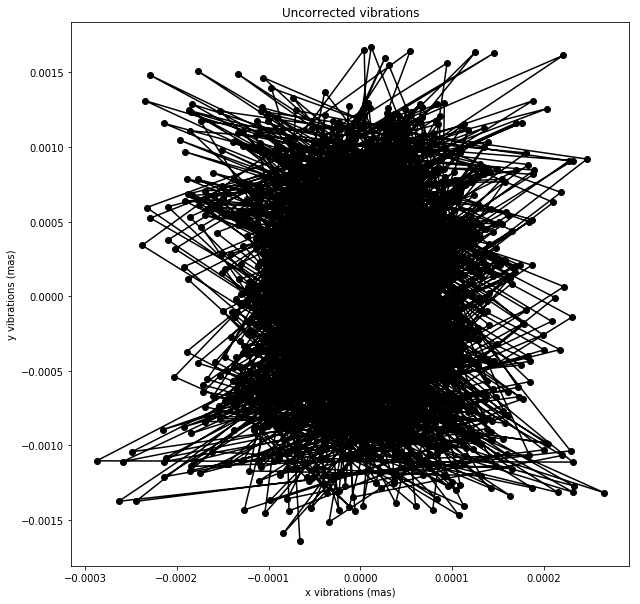

In [16]:
plt.figure(figsize=(10,10))
plt.plot(y[0], y[1], 'ko-')
plt.xlabel("x vibrations (mas)")
plt.ylabel("y vibrations (mas)")
plt.title("Uncorrected vibrations")

Text(0.5,1,'Residual of physics prediction')

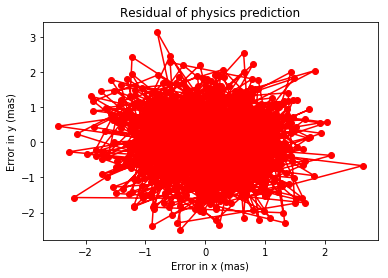

In [17]:
plt.plot(y[0] - dx, y[1] - dy, 'ro-')
plt.xlabel("Error in x (mas)")
plt.ylabel("Error in y (mas)")
plt.title("Residual of physics prediction")

(array([ 705,  823, 1243, 1250, 1388, 1555, 1564, 1595, 1618, 1641, 1692,
        1724]), {})

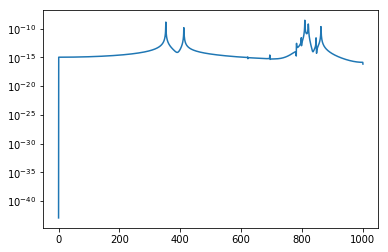

In [18]:
freqs, psd_x_reconstructed = signal.periodogram(y[0], fs=f_sampling)
plt.semilogy(freqs, psd_x_reconstructed)
signal.find_peaks(psd_x_reconstructed)